<a href="https://colab.research.google.com/github/peterpanw/Imageclassifier/blob/main/EANet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
import tensorflow as tf
print("tensorflow version:", tf.__version__)

tensorflow version: 2.6.0


In [ ]:
## Setup
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [ ]:
# Prepare the data
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169017344/169001437 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 100)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 100)


In [ ]:
# Configure the hyperparameters
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 128
num_epochs = 50
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 256


In [ ]:
# Use data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
# Implement the patch extraction and encoding layer
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

In [ ]:
# Implement the external attention block
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [ ]:
# Implement the MLP block
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [ ]:
# Implement the Transformer block
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

In [ ]:
# Implement the EANet model
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Train on CIFAR-100
model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

Epoch 1/50
313/313 [==============================] - 196s 577ms/step - loss: 4.2049 - accuracy: 0.0752 - top-5-accuracy: 0.2438 - val_loss: 3.9870 - val_accuracy: 0.1106 - val_top-5-accuracy: 0.3256
Epoch 2/50
313/313 [==============================] - 178s 569ms/step - loss: 3.7849 - accuracy: 0.1468 - top-5-accuracy: 0.3958 - val_loss: 3.6996 - val_accuracy: 0.1723 - val_top-5-accuracy: 0.4464
Epoch 3/50
313/313 [==============================] - 178s 570ms/step - loss: 3.5396 - accuracy: 0.1991 - top-5-accuracy: 0.4832 - val_loss: 3.5700 - val_accuracy: 0.2092 - val_top-5-accuracy: 0.5035
Epoch 4/50
313/313 [==============================] - 178s 570ms/step - loss: 3.3899 - accuracy: 0.2372 - top-5-accuracy: 0.5353 - val_loss: 3.3750 - val_accuracy: 0.2531 - val_top-5-accuracy: 0.5524
Epoch 5/50
313/313 [==============================] - 178s 569ms/step - loss: 3.2920 - accuracy: 0.2644 - top-5-accuracy: 0.5679 - val_loss: 3.3339 - val_accuracy: 0.2652 - val_top-5-accuracy: 0.5637


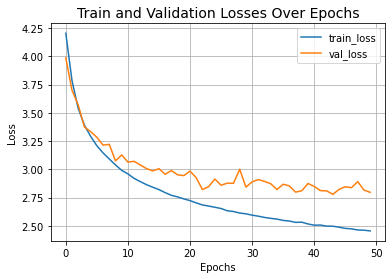

In [ ]:
# Let's visualize the training progress of the model.
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Let's display the final results of the test on CIFAR-100.
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 [==============================] - 26s 83ms/step - loss: 2.7527 - accuracy: 0.4345 - top-5-accuracy: 0.7403
Test loss: 2.75
Test accuracy: 43.45%
Test top 5 accuracy: 74.03%
